In [1]:
import pandas as pd
import numpy as np

from datetime import date

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from plotly.graph_objects import * 
import warnings

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

Выгружаем датасеты и предварительно изучаем

In [2]:
home_page = pd.read_csv('home_page_table.csv')
pay_conf = pd.read_csv('payment_confirmation_table.csv')
pay_page = pd.read_csv('payment_page_table.csv')
search_page = pd.read_csv('search_page_table.csv')
user = pd.read_csv('user_table.csv')
home_page

,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page
...,...,...
90395,456851,home_page
90396,128619,home_page
90397,167290,home_page
90398,437765,home_page


In [3]:
pay_conf

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page
...,...,...
447,397473,payment_confirmation_page
448,860829,payment_confirmation_page
449,371291,payment_confirmation_page
450,263707,payment_confirmation_page


In [4]:
pay_page

,user_id,page
0,253019,payment_page
1,310478,payment_page
2,304081,payment_page
3,901286,payment_page
4,195052,payment_page
...,...,...
6025,23639,payment_page
6026,659242,payment_page
6027,395342,payment_page
6028,637777,payment_page


In [5]:
search_page

,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page
...,...,...
45195,417880,search_page
45196,989982,search_page
45197,428806,search_page
45198,609493,search_page


In [6]:
user

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male
...,...,...,...,...
90395,307667,2015-03-30,Desktop,Female
90396,642989,2015-02-08,Desktop,Female
90397,659645,2015-04-13,Desktop,Male
90398,359779,2015-03-23,Desktop,Male


Мы видим по датафреймам, что у нас воронка продаж. Попробуем всё объеденить через датафрейм со всеми пользователями

In [7]:
df = pd.merge_ordered(user, home_page)
df['Date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df.set_index('Date', inplace=True)

In [8]:
df_users = pd.DataFrame(df['date'].value_counts()).sort_values(by='date')

In [9]:
df1 = pd.merge_ordered(user, search_page)
df1['Date'] = pd.to_datetime(df1['date'])
df1 = df1.sort_values(by='date')
df1.set_index('Date', inplace=True)
df1 = df1[['date', 'page']].dropna()

In [10]:
df_search = pd.DataFrame(df1['date'].value_counts()).sort_values(by='date')

In [11]:
df2 = pd.merge_ordered(user, pay_page)
df2['Date'] = pd.to_datetime(df2['date'])
df2 = df2.sort_values(by='date')
df2.set_index('Date', inplace=True)
df2 = df2[['date', 'page']].dropna()

In [12]:
df_pay = pd.DataFrame(df2['date'].value_counts()).sort_values(by='date')

In [13]:
df3 = pd.merge_ordered(user, pay_conf)
df3['Date'] = pd.to_datetime(df3['date'])
df3 = df3.sort_values(by='date')
df3.set_index('Date', inplace=True)
df3 = df3[['date', 'page']].dropna()

In [14]:
df_conf = pd.DataFrame(df3['date'].value_counts()).sort_values(by='date')

In [15]:
df_users['users'] = df_users['date']
df_search['searches'] = df_search['date']
df_pay['payment'] = df_pay['date']
df_conf['confirmed'] = df_conf['date']
df_users['date'] = df_users.index
df_search['date'] = df_search.index
df_pay['date'] = df_pay.index
df_conf['date'] = df_conf.index

In [16]:
df_final = pd.merge(df_users, df_search)

In [17]:
df_final

,date,users,searches
0,2015-01-18,668,422
1,2015-03-19,684,272
2,2015-01-26,686,402
3,2015-01-13,693,421
4,2015-03-27,693,265
...,...,...,...
115,2015-02-25,830,508
116,2015-02-15,835,506
117,2015-02-02,845,511
118,2015-02-07,846,506


Теперь визуализируем каждый этап воронки

<AxesSubplot:xlabel='date'>

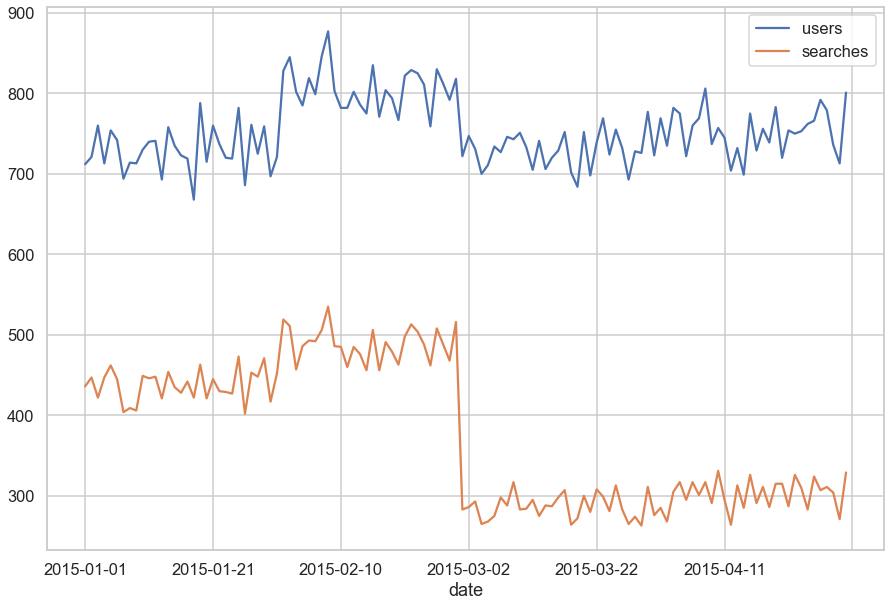

In [18]:
df_final = pd.merge(df_final, df_pay)
df_final = df_final.sort_values(by='date')
df_final.set_index('date')[['users', 'searches']].plot()

Средние показатели

In [45]:
df_final.set_index('date')[['users', 'searches']][31:59].mean()

users       807.142857
searches    488.821429
dtype: float64

In [56]:
df_final.set_index('date')[['users', 'searches']][59:].mean()

users       740.983607
searches    294.409836
dtype: float64

<AxesSubplot:xlabel='date'>

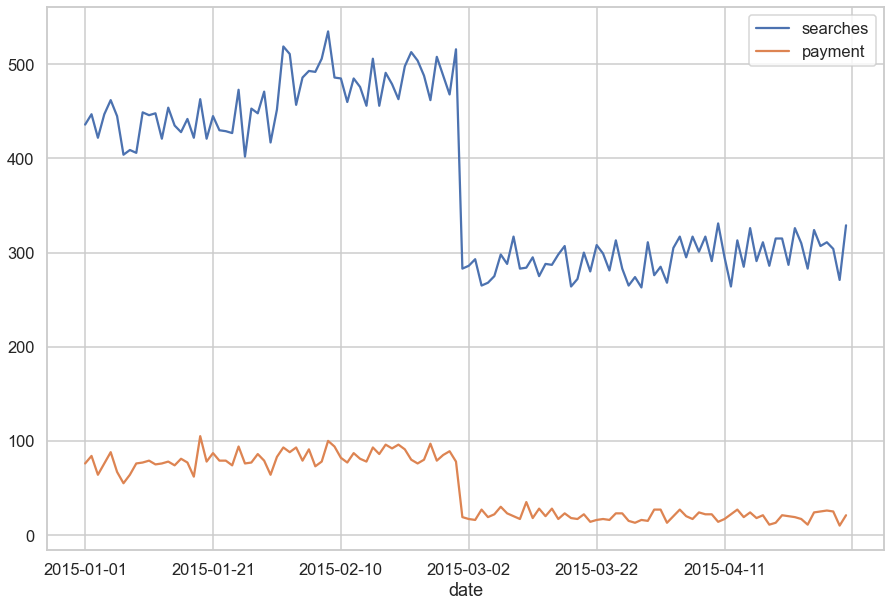

In [19]:
df_final.set_index('date')[['searches', 'payment']].plot()

Средние показатели

In [46]:
df_final.set_index('date')[['searches', 'payment']][31:59].mean()

searches    488.821429
payment      86.142857
dtype: float64

In [57]:
df_final.set_index('date')[['searches', 'payment']][59:].mean()

searches    294.409836
payment      20.131148
dtype: float64

<AxesSubplot:xlabel='date'>

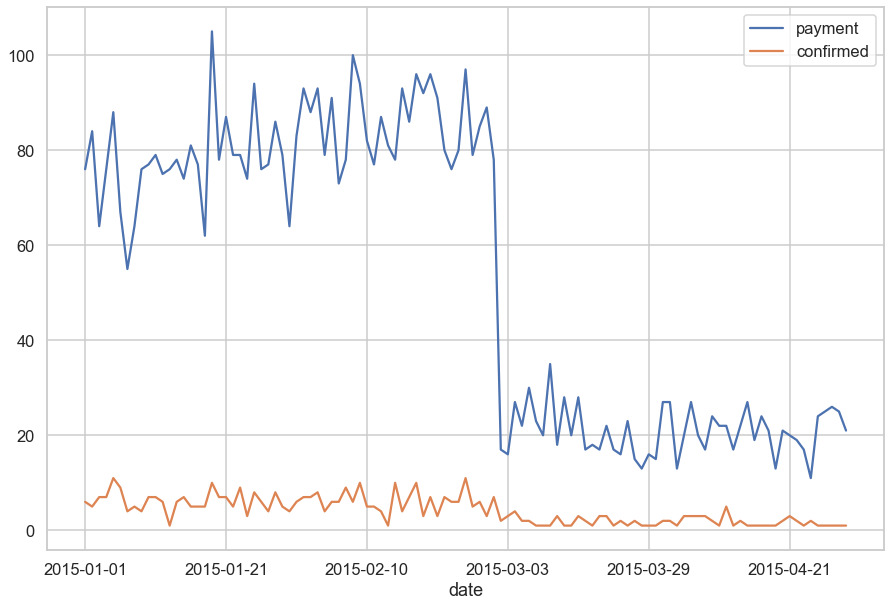

In [20]:
df_final_1 = pd.merge(df_final, df_conf)
df_final_1 = df_final_1.sort_values(by="date")
df_final_1.set_index(df_final_1['date'])[['payment', 'confirmed']].plot()

Средние показатели

In [60]:
df_final_1.set_index(df_final_1['date'])[['payment', 'confirmed']][31:59].mean()

payment      86.142857
confirmed     6.178571
dtype: float64

In [58]:
df_final_1.set_index(df_final_1['date'])[['payment', 'confirmed']][59:].mean()

payment      20.88
confirmed     1.80
dtype: float64

In [21]:
df_final_1.set_index(df_final_1['date'])[['payment', 'confirmed']]

,payment,confirmed
date,,
2015-01-01,76,6
2015-01-02,84,5
2015-01-03,64,7
2015-01-04,76,7
2015-01-05,88,11
...,...,...
2015-04-25,24,1
2015-04-26,25,1
2015-04-27,26,1


<AxesSubplot:xlabel='date'>

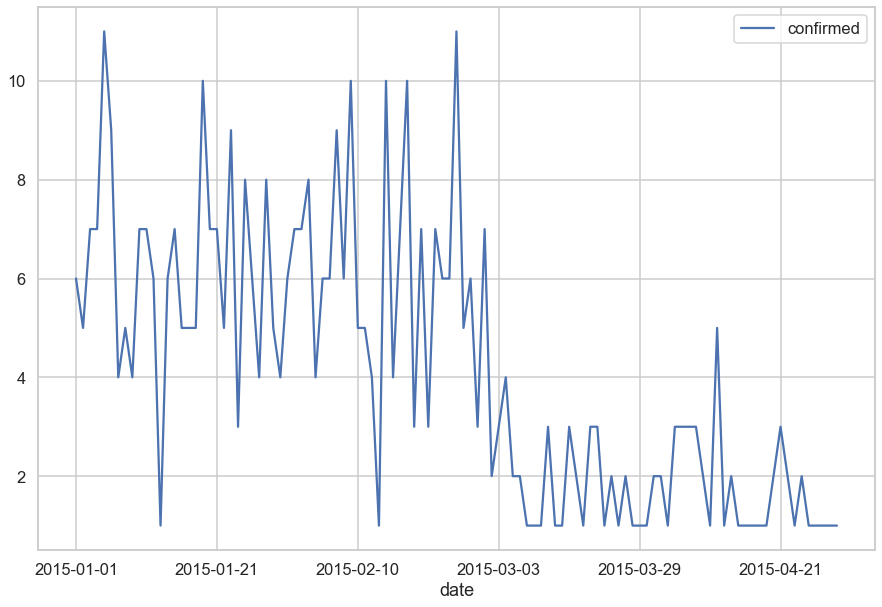

In [22]:
df_final_1.set_index(df_final_1['date'])[['confirmed']].plot()

 По распределению данных на графиках понятно, что случилось резкое падение активности клиентов вцелом, хотя их количество осталось на том же уровне. Изначально был небольшой подъём количества клиенто, поисков и заказов примерно с 2015-02-01. В этот период количество клиентов в среднем 800, количество поисков в среднем 488, количество страниц с оплатой до которой дошли клиенти 86 и оплаты в среднем не изменились с начала наблюдений, их среднее количество осталось 6. После 2015-03-01	наблюдается резкое падение всех показателей кроме количества клиентов в день, их количество упало не сильно, в срднем на 60 до 640 клиентов в день. А вот количество поисков(запросов) снизилось очень сильно. Для поисков до 294 в среднем, для страниц с оплатой до 20 в день в среднем и для оплат до 1.8 в среднем. Некоторые дни были с нудевыми оплатами в этот период.
Неожиданное падение началось именно с началом марта